## OBJECTIVE

### Customer Lifetime Value

## Imports

### Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer #extract bag of words
from sklearn.feature_selection import SelectPercentile

import warnings
warnings.filterwarnings("ignore")

### For NLP

In [2]:
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim

### Modeling

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV, train_test_split

### Evaluation

In [4]:
from sklearn.feature_selection import SelectPercentile, chi2, f_classif

### Standards

In [5]:
import sys
sys.path.append("../../Standards")

In [6]:
from explanations import get_regression_stats, displaycoef
from ds_common import complete_evaluation

### Native Function

In [7]:
def dummies(series):
    """
    Accepts a pandas Series to categorized
    """   
    
    #hasnull = False
    
    if series.isnull().sum() > 0:
        series = series.fillna(f"Uncategorized_{series.name}")
        
    series = series.str.strip()
    series = series.str.title()
    pd_dummy = [{(f"{series.name}_{a}") : b} for a, b in zip(series, pd.Series(np.full(len(series), 1)))]
    pd_dummy = pd.DataFrame(pd_dummy).fillna(0).astype(int)
    
    
    return pd_dummy

In [8]:
def nlp_cleaner(string_series, word_length_tolerance = 2):

    sent_series = []
    
    for sentence in string_series:
        result = []
        if isinstance(sentence, str) == True:
            for token in gensim.utils.simple_preprocess(sentence):
                if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > word_length_tolerance:
                    result.append(WordNetLemmatizer().lemmatize(token, pos = "v"))
        else:
            result.append("No String Found")

        word_string = " ".join(word for word in result)
        sent_series.append(word_string)
        
    return sent_series

### Dataset

In [9]:
data_cct = pd.read_excel("../Data/COF Customer Lifetime Data.xlsx", sheet_name = "CCT")
data_hbc = pd.read_excel("../Data/COF Customer Lifetime Data.xlsx", sheet_name = "HBC")

In [10]:
print(f"Data CCT: {data_cct.shape}")
print(f"Data HBC: {data_hbc.shape}")

Data CCT: (1548, 101)
Data HBC: (240, 97)


### Selecting the columns that will be use for modeling

In [11]:
selected_features = ["Workweek",
                     "FCR",
                     "Call Type",
                     "Sub Call Type",
                     "Summary",
                     
                     #Customer Detals
                     "Gender",
                     "Age",
                     "Province",
                     "Employment Status",
                     "Type of MasterCard",
                     "Enrolled in Online Banking",
                     "Enrolled in Paperless Statements",
                     "Enrolled in Paperless Documents",
                     "Current Account Standing",
                    ]

data_cct = data_cct[selected_features]
print(f"Data CCT: {data_cct.shape}")

Data CCT: (1548, 14)


## Cleaning

### Learning how messy the data is

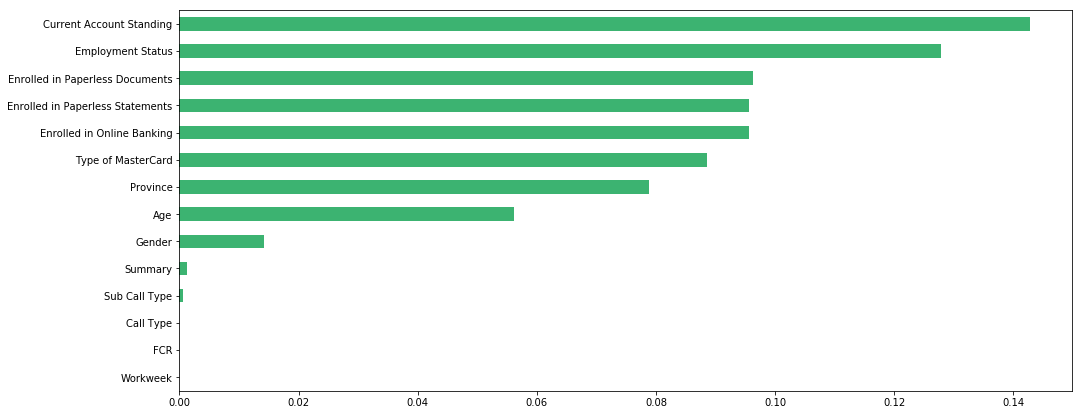

In [12]:
missing_val = (len(data_cct) - data_cct.count()) / len(data_cct)
missing_val = missing_val.sort_values(ascending = True)

fig = plt.figure(figsize = (16, 7))
ax = fig.add_subplot(111)
missing_val.plot.barh(color = "mediumseagreen", ax = ax);

#labels = [round(float(item.get_text()) * 100) for item in ax.get_xticklabels()]
#labels = ["{}{}".format(v,"%") for v in labels]
#ax.set_xticklabels(labels);

### Managing Duplicate Summaries

In [13]:
print(f"Total cases that were identified as duplicates: {(data_cct['Summary'].duplicated() == True).sum()}")

Total cases that were identified as duplicates: 144


We have identified several cases that appeared to be the same based from the summary of the case. What makes it an anomaly is that some of them do not share the same call type but has the same summary.

In [14]:
pd.set_option("display.max_colwidth", -1)

In [15]:
duplicates = data_cct[["Call Type", "Sub Call Type", "Summary"]]
duplicates[duplicates.duplicated(subset = ["Summary"], keep=False)].head(10)

,Call Type,Sub Call Type,Summary
34,Card Activation,Activation,"The customer called in to activate his card. Vebs provided the activation process wherein the customer got confused on what he needs to do. She then explained it again to the customer. The customer then asked for the credit limit he was approved and if he can use the card right away. Vebs provided the credit limit fo the account and informed the customer that he can start using the card once its been activated. The customer then asked how he can make payments on the acccount is he can go to the bank or do it online. Vebs placed the call on hold and when he gets back to the customer he told the customer that he can pay the account electronically which will take within 3 business days to post. The customer didn't get what's she means by electronic payment wherein she explained that he can do it thru internet banking, ATM or telebanking. Call ended."
35,Account Information,Terms,"The customer called in to activate his card. Vebs provided the activation process wherein the customer got confused on what he needs to do. She then explained it again to the customer. The customer then asked for the credit limit he was approved and if he can use the card right away. Vebs provided the credit limit fo the account and informed the customer that he can start using the card once its been activated. The customer then asked how he can make payments on the acccount is he can go to the bank or do it online. Vebs placed the call on hold and when he gets back to the customer he told the customer that he can pay the account electronically which will take within 3 business days to post. The customer didn't get what's she means by electronic payment wherein she explained that he can do it thru internet banking, ATM or telebanking. Call ended."
36,Payment,Payment inquiry,"The customer called in to activate his card. Vebs provided the activation process wherein the customer got confused on what he needs to do. She then explained it again to the customer. The customer then asked for the credit limit he was approved and if he can use the card right away. Vebs provided the credit limit fo the account and informed the customer that he can start using the card once its been activated. The customer then asked how he can make payments on the acccount is he can go to the bank or do it online. Vebs placed the call on hold and when he gets back to the customer he told the customer that he can pay the account electronically which will take within 3 business days to post. The customer didn't get what's she means by electronic payment wherein she explained that he can do it thru internet banking, ATM or telebanking. Call ended."
50,Customer Transaction,Temporary restriction or declined transaction,The customer called in due to a declined charge from yesterday. Gen advised the customer that the card needed to be activated that is why it didn't go through. Gen helped the customer activate the card.
51,Card Activation,Activation,The customer called in due to a declined charge from yesterday. Gen advised the customer that the card needed to be activated that is why it didn't go through. Gen helped the customer activate the card.
60,Customer Transaction,Transaction inquiry,The customer called in because she made a payment online for the remaining balance yesterday yet it doesn't show yet on her account. The agent informed the customer that payment made online would take within 3 business days to post. The customer also asked for the available balance left and inquired if the transaction worth $1400 will go through. The agent provided the available balance left and informed the customer that the transaction would possibly be declined due to insufficient funds.
61,Account Information,Balance and Available Credit,The customer called in because she made a payment online for the remaining balance yesterday yet it doesn't show yet on her account. The agent informed the customer that payment made online would take

Dropping the duplicates found in the dataset

In [16]:
clean_cct = data_cct.drop_duplicates(subset = "Summary", keep = "last")
clean_cct.shape

(1404, 14)

### Managing Duplicate Labels in each column

In [17]:
df_calltype = dummies(clean_cct["Call Type"])
df_subcalltype = dummies(clean_cct["Sub Call Type"])
df_gender = dummies(clean_cct["Gender"])
df_province = dummies(clean_cct["Province"])
df_empstat = dummies(clean_cct["Employment Status"])
df_cardtype = dummies(clean_cct["Type of MasterCard"])
df_creditscore = dummies(clean_cct["Current Account Standing"])

In [18]:
clean_cct["Call Type"].str.title().value_counts().sort_values(ascending = True)

Account Information     187
Service Experience      192
Payment                 196
Customer Transaction    197
Card Activation         199
Card Application        216
Credit Card Plastics    217
Name: Call Type, dtype: int64

In [19]:
clean_cct["Sub Call Type"].str.title().value_counts().sort_values(ascending = True)

Fraud                                            1  
Merchant Verification                            1  
Account Terms                                    1  
Receiving Of Payment                             1  
Card Not Working                                 2  
Agent Interaction                                3  
Misapplied Payment                               3  
Pre-Authorized Or Pending                        4  
Request For Renewal Card                         9  
Escalation Process                               10 
Credit Balance Refund                            10 
General Features And Benefits                    12 
Account Status                                   13 
Cash Advance - Inquiry                           14 
Aml Or Kyc                                       15 
Mobile App                                       16 
Terms                                            19 
Request For Replacement Card                     19 
Payment Options Or Method                     

In [20]:
clean_cct["Gender"].str.title().value_counts().sort_values(ascending = True)

Mock Call    1  
Female       652
Male         733
Name: Gender, dtype: int64

In [21]:
clean_cct["Province"].str.title().value_counts().sort_values(ascending = True)

Mock Call    1  
Nt           2  
Pe           2  
Yt           2  
Nl           16 
Sk           31 
Nb           31 
Ns           43 
Mb           45 
Qc           54 
Bc           172
Ab           188
On           710
Name: Province, dtype: int64

#### Employment Status

In [22]:
clean_cct["Employment Status"].str.title().value_counts().sort_values(ascending = True)

Mock Call        1  
Self Employed    4  
Student          5  
Unemployed       104
Self-Employed    123
Retired          141
Employed         848
Name: Employment Status, dtype: int64

Labeling Error:
    - "Self Employed" : "Self-Employed"

In [23]:
clean_cct["Employment Status"].replace({"Self Employed" : "Self-Employed"}, inplace = True)

#### Type of MasterCard

In [24]:
clean_cct["Type of MasterCard"].str.title().value_counts().sort_index(ascending = True)

Aspire Platinum Cash                  8  
Aspire Platinum Miles                 20 
Aspire Travel World Elite Mc          3  
Canada High Response                  234
Canada Platinum                       1  
Canada Platinum Mastercard            1  
Canada Prime                          23 
Canada Prime Mastercard               4  
Canada Super Prime                    1  
Canada Superprime                     4  
Canada Superrime                      1  
Costco                                1  
Costco Platinum Mastercard            9  
Gold Mastercard                       586
Guaranteed Mastercard                 5  
Mastercard                            4  
Mastercard Platinum                   7  
Mastercard Platinum (Canada Prime)    4  
Mastercard Platinum Card              2  
Mastercard Worldcard                  1  
Mock Call                             1  
Platinum (Canada Prime)               4  
Platinum Mastercard (Canada Prime)    7  
Platinum Mastercard (Super Prime) 

For Validation:

    - "Canada Platinum Mastercard" : "Canada Platinum"
    - "Super Prime" : "Superprime"
    - "Superrime" : "Superprime"
    - "Platinum (Canada Prime)" : "Platinum Mastercard (Canada Prime)"
    - "Smart Line - Platinum" : "Smartline Platinum"
    - "Smart Line Platinum" : "Smartline Platinum"

In [25]:
mapper = {"Aspire Platinum Cash" : "Aspire Platinum Miles",
          "Aspire Travel World Elite MC" : "Aspire Platinum Miles",
          
          "Canada Platinum" : "Canada Platinum MasterCard",
          "Canada Platinum MasterCard" : "Canada Platinum MasterCard",
          "Platinum MasterCard (Canada Prime)" : "Canada Platinum MasterCard",
          
          "Canada Prime MasterCard" : "Canada Prime",
          
          "Canada Super Prime" : "Canada Superprime",
          "Canada Superrime" : "Canada Superprime",
          
          "Gold Mastercard" : "Gold MasterCard",
          
          "MasterCard Platinum (Canada Prime)" : "MasterCard Platinum",
          "Mastercard Platinum" : "MasterCard Platinum",
          "Mastercard Platinum Card" : "MasterCard Platinum",
          
          "Platinum (Canada Prime)" : "Platinum MasterCard (Canada Prime)",
          
          "Secured Mastercard" : "Secured MasterCard",
          
          "Smart Line Platinum" : "Smartline Platinum",
          "Smart Line - Platinum" : "Smartline Platinum",
          "smart line platinum" : "Smartline Platinum",
          
          "World Elite Mastercard" : "World Elite MasterCard",
          
          "Costco" : "Costco Platinum MasterCard"
         }

clean_cct["Type of MasterCard"].replace(mapper, inplace = True)

#### Call Type

In [26]:
clean_cct["Call Type"].value_counts().sort_index()

Account Information     186
Account information     1  
Card Activation         199
Card Application        216
Credit Card Plastics    217
Customer Transaction    197
Payment                 196
Service Experience      192
Name: Call Type, dtype: int64

In [27]:
mapper = {"Account information" : "Account Information"}

clean_cct["Call Type"].replace(mapper, inplace = True)

In [28]:
clean_cct["Sub Call Type"].value_counts().sort_index()

AML or KYC                                       15 
Account Status                                   13 
Account Terms                                    1  
Activation                                       199
Agent interaction                                3  
Application (process)                            79 
Application status                               122
Balance and Available Credit                     129
CHIP - PIN                                       101
Card not working                                 2  
Cash advance - Inquiry                           14 
Credit balance refund                            10 
Credit card not received                         42 
Dispute                                          34 
Escalation Process                               10 
Fraud                                            1  
General Features and Benefits                    12 
Merchant Verification                            1  
Misapplied payment                            

In [29]:
mapper = {"Online Banking" : "Online banking",
          "Payment inquiry" : "Payment Inquiry"
         }

clean_cct["Sub Call Type"].replace(mapper, inplace = True)

#### Current Account Standing

In [30]:
clean_cct["Current Account Standing"].str.title().value_counts().sort_index(ascending = True)

Bad Standing (Overlimit/Past Due/Credit Revoked/Coded To Collections/Recoveries)    166 
Good Standing                                                                       1048
Mock Call                                                                           1   
Yes                                                                                 1   
Name: Current Account Standing, dtype: int64

Removing the "Yes" remark

In [31]:
mapper = {"Bad Standing (Overlimit/Past Due/Credit Revoked/Coded to Collections/Recoveries)" : 0,
          "Good Standing" : 1}

clean_cct["Current Account Standing"] = clean_cct["Current Account Standing"].map(mapper)

### Cleaning all numeric columns and returns NaN to non-numerical columns

In [32]:
numerical_cols = ["Workweek", "Age"]

for v in numerical_cols:
    clean_cct[v] = pd.to_numeric(clean_cct[v], errors = "coerce")

### Mapping Boolean values

In [33]:
clean_cct["FCR"].replace({"Yes" : 1, "No" : 0}, inplace = True)

clean_cct["Enrolled in Online Banking"].replace({"Yes" : 1, "No" : 0}, inplace = True)
clean_cct["Enrolled in Paperless Statements"].replace({"Yes" : 1, "No" : 0}, inplace = True)
clean_cct["Enrolled in Paperless Documents"].replace({"Yes" : 1, "No" : 0}, inplace = True)

### Removing some weird values

In [34]:
clean_cct = clean_cct.loc[~data_cct["Gender"].str.contains("mock call",
                                                         case = False,
                                                         na = False)]

In [35]:
data_cct["Current Account Standing"].count()

1327

In [36]:
clean_cct = clean_cct.loc[~data_cct["Current Account Standing"].str.contains("yes",
                                                                             case = False,
                                                                             na = False)]

In [37]:
clean_cct = clean_cct.dropna() 

In [38]:
clean_cct["Enrolled in Online Banking"] = clean_cct["Enrolled in Online Banking"].astype(int)
clean_cct["Enrolled in Paperless Statements"] = clean_cct["Enrolled in Paperless Statements"].astype(int)
clean_cct["Enrolled in Paperless Documents"] = clean_cct["Enrolled in Paperless Documents"].astype(int)

### Making sure that every string-based column don't have any unnecessary spaces

In [39]:
for v in clean_cct.select_dtypes(include = ("object", "category")):
    clean_cct[v] = clean_cct[v].str.strip()

### Reset index

In [40]:
clean_cct = clean_cct.reset_index(drop = True)

## Feature Engineering

#### Categorical Columns

In [41]:
df_calltype = dummies(clean_cct["Call Type"])
df_subcalltype = dummies(clean_cct["Sub Call Type"])
df_gender = dummies(clean_cct["Gender"])
df_province = dummies(clean_cct["Province"])
df_empstat = dummies(clean_cct["Employment Status"])
df_cardtype = dummies(clean_cct["Type of MasterCard"])

In [42]:
clean_cct["Current Account Standing"] = clean_cct["Current Account Standing"].astype(int)

### Common things observed when you have good/bad Account Standing

- 1 = Good
- 0 = Bad

In [43]:
clean_cct["Summary"] = nlp_cleaner(clean_cct["Summary"])

In [44]:
df_pos_accountstanding = clean_cct.loc[clean_cct["Current Account Standing"] == 1]
df_neg_accountstanding = clean_cct.loc[clean_cct["Current Account Standing"] == 0]

#### Bag of Words

In [45]:
#Unigram
vectorizer = CountVectorizer(ngram_range = (1,1))
countvec = vectorizer.fit_transform(df_pos_accountstanding["Summary"])
df_countvec_unigram = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())

#Bigram
vectorizer = CountVectorizer(ngram_range = (2,2))
countvec = vectorizer.fit_transform(df_pos_accountstanding["Summary"])
df_countvec_bigram = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())

In [46]:
dfs = [clean_cct, df_calltype, df_subcalltype, df_gender, df_province,
       df_empstat, df_cardtype, df_countvec_bigram
      ]

consolidated_df = reduce(lambda left, right: pd.merge(left, right,
                                                      left_index = True,
                                                      right_index = True
                                                      ), dfs)

## EDA

In [47]:
drop_cols = ['Workweek',
             'FCR',
             'Call Type',
             'Sub Call Type',
             'Summary',
             'Gender',
             'Age',
             'Province',
             'Employment Status',
             'Type of MasterCard',
            ]

processed_data = consolidated_df.drop(columns = drop_cols)

In [48]:
processed_data.shape

(981, 7966)

In [49]:
processed_data.head(4)

,Enrolled in Online Banking,Enrolled in Paperless Statements,Enrolled in Paperless Documents,Current Account Standing,Call Type_Account Information,Call Type_Card Activation,Call Type_Card Application,Call Type_Credit Card Plastics,Call Type_Customer Transaction,Call Type_Payment,...,yesterday online,yneed settle,young life,zero advise,zero application,zero balance,zero customer,zero end,zero liability,zip code
0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Total Cases Per Workweek

Total Cases : 981
Average Cases : 245.25


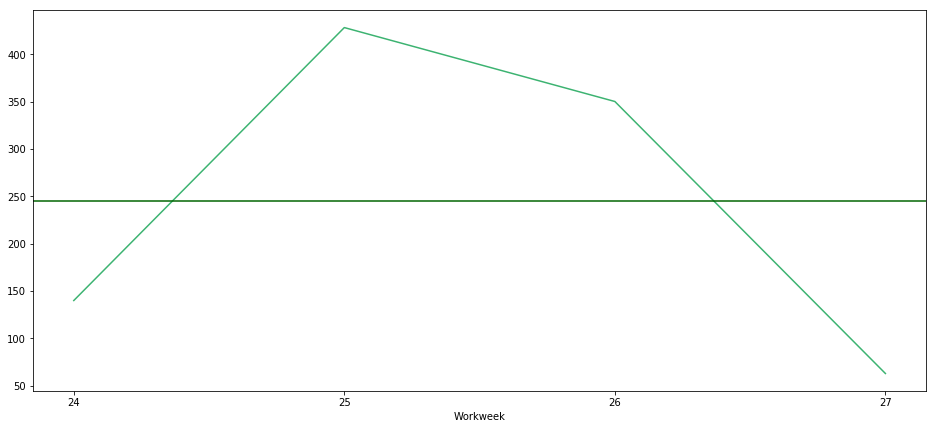

In [50]:
get_data = consolidated_df.groupby(["Workweek"])["Age"].count().sort_index(ascending = False)

fig = plt.figure(figsize = (16, 7))
ax = fig.add_subplot(111)

get_data.plot.line(color = "mediumseagreen", ax = ax)
ax.set_xticks(np.arange(min(get_data.index), max(get_data.index) + 1, step = 1));
ax.axhline(y = get_data.mean(), color = "darkgreen", linestyle = "-")
print(f"Total Cases : {get_data.sum()}")
print(f"Average Cases : {get_data.mean()}")

In [51]:
consolidated_df

,Workweek,FCR,Call Type,Sub Call Type,Summary,Gender,Age,Province,Employment Status,Type of MasterCard,...,yesterday online,yneed settle,young life,zero advise,zero application,zero balance,zero customer,zero end,zero liability,zip code
0,24,1,Customer Transaction,Temporary restriction or declined transaction,customer call try use card get decline agent inform customer decline transaction today transaction june customer ask credit limit increase agent wasn able respond customer hang,Female,38.739726,ON,Unemployed,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0
1,24,0,Payment,Payment options or method,customer call ask fastest way payment post ask payment phone agent inform customer aren allow accept payments phone advise customer process payment online fastest business days customer hang,Male,26.871233,ON,Employed,Secured MasterCard,...,0,0,0,0,0,0,0,0,0,0
2,24,1,Card Activation,Activation,customer call activate card want use pin replacement card agent duscussed activation process transfer ivr,Female,53.153425,ON,Unemployed,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0
3,24,1,Card Activation,Activation,customer call activate card agent ask customer pin customer say haven recevied agent inform customer pin mailer arrive business days advise callback receive pin card activation end,Male,47.369863,ON,Employed,Secured MasterCard,...,0,0,0,0,0,0,0,0,0,0
4,24,0,Credit Card Plastics,Credit card not received,customer call receive statement bill haven receive new card agent inform customer account formally close confirmation customer successfully verification canada post advise customer reapply end properly,Male,26.000000,NS,Student,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0
5,24,1,Card Activation,Activation,customer call setup online bank account want activate card haven receive pin agent advise customer receive card today need wait business days way generate pin end,Female,36.558904,ON,Employed,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0
6,24,0,Customer Transaction,Credit balance refund,customer call accidentally overpayment accoutn request refund agent verify customer mail address advise credit balance refund cheque process days additional days mail brand,Male,40.227397,ON,Employed,MasterCard Platinum,...,0,0,0,0,0,0,0,0,0,0
7,24,0,Account Information,Balance and Available Credit,customer call payment yesterday ask use card agent inform customer payment post business days online advise customer use card available credit advise customer avoid get limit charge limit fee educate customer check online bank payment post,Female,62.463014,ON,Retired,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0
8,24,0,Credit Card Plastics,CHIP - PIN,customer call forget pin eugine verify customer send pin mailer business days cal brand,Female,34.000000,NB,Employed,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0
9,24,0,Customer Transaction,Temporary restriction or declined transaction,customer call transaction decline eugine verify customer inform exceed maximum attempt enter pin inform customer connect ivr unlock pin,Male,56.000000,QC,Employed,Gold MasterCard,...,0,0,0,0,0,0,0,0,0,0


### User's Age

#### Tied to their Location

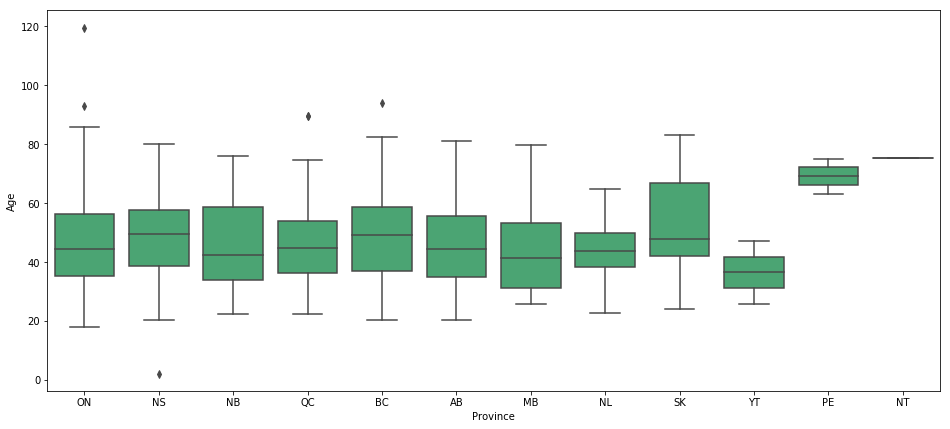

In [52]:
fig = plt.figure(figsize = (16, 7))
ax = fig.add_subplot(111)

sns.boxplot(x = "Province", y = "Age", data = clean_cct, color = "mediumseagreen");

In [53]:
get_data = clean_cct.groupby(["Province"])["Age"].count().sort_values(ascending = False)
get_data

Province
ON    630
AB    168
BC    151
QC    47 
MB    39 
NS    38 
SK    26 
NB    24 
NL    13 
YT    2  
PE    2  
NT    1  
Name: Age, dtype: int64

#### Tied to their Employment Status

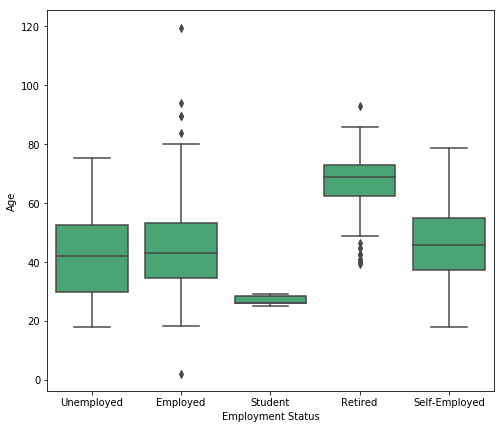

In [54]:
fig = plt.figure(figsize = (8, 7))
ax = fig.add_subplot(111)

sns.boxplot(x = "Employment Status", y = "Age", data = clean_cct, color = "mediumseagreen");

In [55]:
get_data = clean_cct.groupby(["Employment Status"])["Age"].count().sort_values(ascending = False)
get_data

Employment Status
Employed         784
Retired          137
Self-Employed    116
Unemployed       99 
Student          5  
Name: Age, dtype: int64

### Most used type of card

In [56]:
get_data = clean_cct.groupby(["Type of MasterCard"])["Age"].count().sort_values(ascending = False)
get_data

Type of MasterCard
Gold MasterCard                       537
Secured MasterCard                    261
Canada High Response                  216
Aspire Platinum Miles                 27 
Canada Prime                          23 
World Elite MasterCard                15 
Smartline Platinum                    15 
MasterCard Platinum                   13 
Canada Platinum MasterCard            9  
Costco Platinum MasterCard            8  
Canada Superprime                     6  
Platinum MasterCard (Canada Prime)    4  
Platinum MasterCard (Super Prime)     3  
MasterCard                            3  
Mastercard Worldcard                  1  
Name: Age, dtype: int64

#### Common Words - Unigram

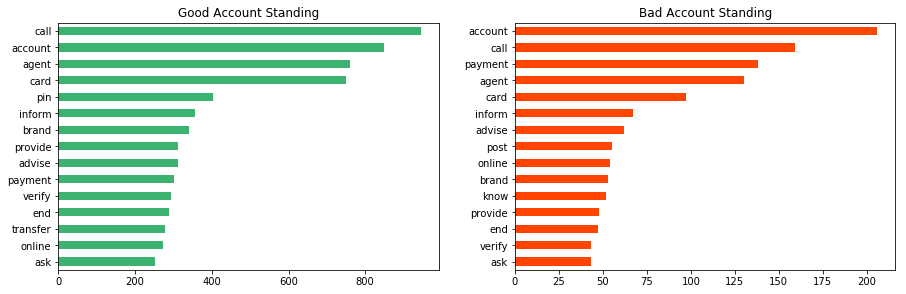

In [57]:
vectorizer = CountVectorizer()
fig = plt.figure(figsize = (15, 10))

countvec = vectorizer.fit_transform(df_pos_accountstanding["Summary"])
df_countvec = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())
ax = fig.add_subplot(221)
df_countvec.sum(axis = 0).sort_values(ascending = False)[1:16][::-1].plot.barh(color = "mediumseagreen", ax = ax)
ax.set_title("Good Account Standing")

countvec = vectorizer.fit_transform(df_neg_accountstanding["Summary"])
df_countvec = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())
ax2 = fig.add_subplot(222)
df_countvec.sum(axis = 0).sort_values(ascending = False)[1:16][::-1].plot.barh(color = "orangered", ax = ax2)
ax2.set_title("Bad Account Standing");

#### Common Words - Bigram

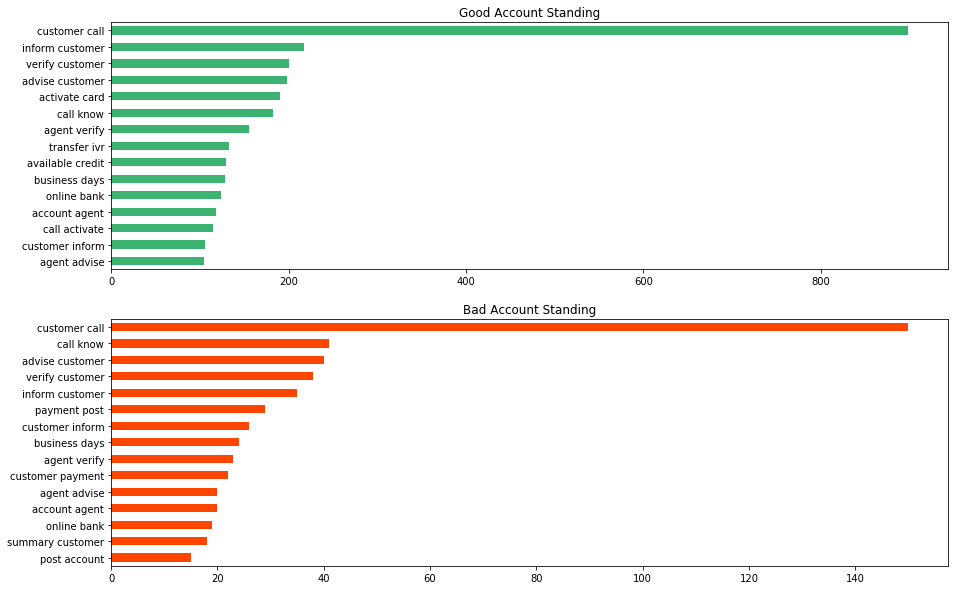

In [58]:
vectorizer = CountVectorizer(ngram_range = (2,2))
fig = plt.figure(figsize = (15, 10))

countvec = vectorizer.fit_transform(df_pos_accountstanding["Summary"])
df_countvec = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())
ax = fig.add_subplot(211)
df_countvec.sum(axis = 0).sort_values(ascending = False)[:15][::-1].plot.barh(color = "mediumseagreen", ax = ax)
ax.set_title("Good Account Standing")

countvec = vectorizer.fit_transform(df_neg_accountstanding["Summary"])
df_countvec = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())
ax2 = fig.add_subplot(212)
df_countvec.sum(axis = 0).sort_values(ascending = False)[:15][::-1].plot.barh(color = "orangered", ax = ax2);
ax2.set_title("Bad Account Standing");

#### Common Words - Trigram

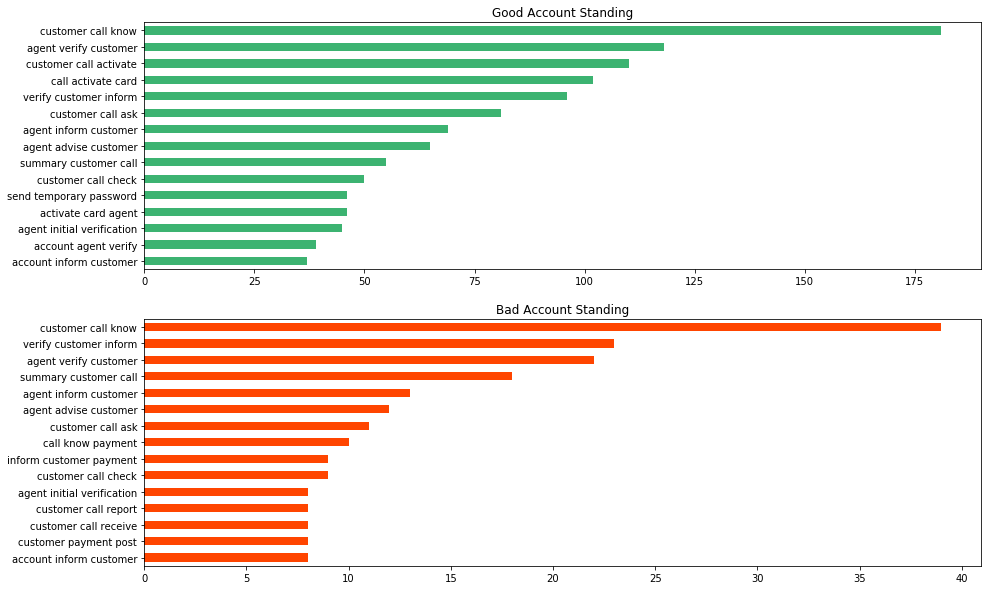

In [59]:
vectorizer = CountVectorizer(ngram_range = (3,3))
fig = plt.figure(figsize = (15, 10))

countvec = vectorizer.fit_transform(df_pos_accountstanding["Summary"])
df_countvec = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())
ax = fig.add_subplot(211)
df_countvec.sum(axis = 0).sort_values(ascending = False)[:15][::-1].plot.barh(color = "mediumseagreen", ax = ax)
ax.set_title("Good Account Standing")

countvec = vectorizer.fit_transform(df_neg_accountstanding["Summary"])
df_countvec = pd.DataFrame(countvec.toarray(), columns = vectorizer.get_feature_names())
ax2 = fig.add_subplot(212)
df_countvec.sum(axis = 0).sort_values(ascending = False)[:15][::-1].plot.barh(color = "orangered", ax = ax2)
ax2.set_title("Bad Account Standing");

#### Call Types Related to Good and Bad Standing

In [60]:
df_pos_accountstanding.groupby(["Call Type"])["Call Type"].count() / df_pos_accountstanding.groupby(["Call Type"])["Call Type"].count().sum()

Call Type
Account Information     0.143731
Card Activation         0.169215
Card Application        0.062181
Credit Card Plastics    0.170234
Customer Transaction    0.165138
Payment                 0.134557
Service Experience      0.154944
Name: Call Type, dtype: float64

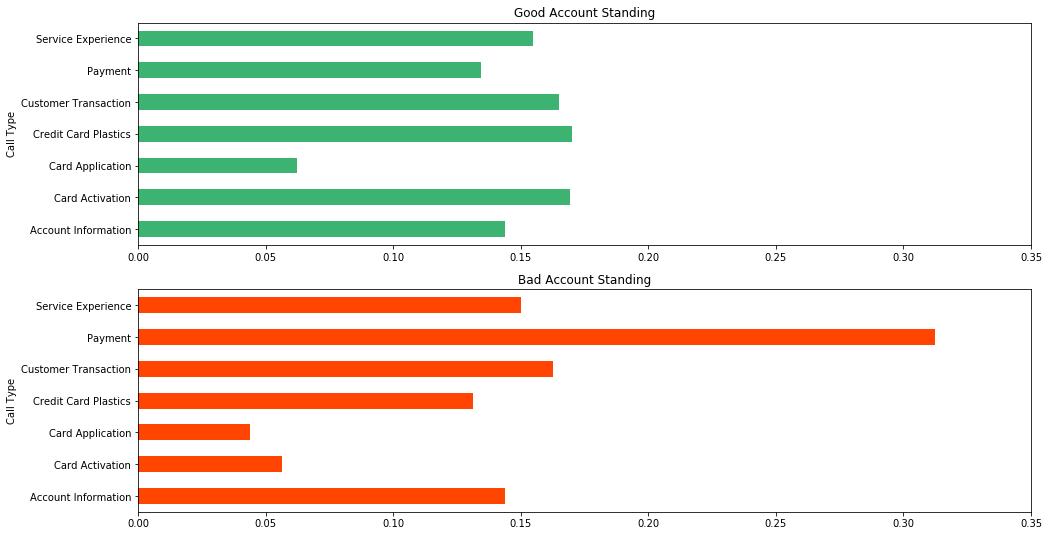

In [61]:
fig = plt.figure(figsize = (16, 9))


ax = fig.add_subplot(211)
(df_pos_accountstanding.groupby(["Call Type"])["Call Type"].count() / df_pos_accountstanding.groupby(["Call Type"])["Call Type"].count().sum()).plot.barh(color = "mediumseagreen", ax = ax)
ax.set_xlim(0, 0.35)
ax.set_title("Good Account Standing")

ax2 = fig.add_subplot(212)
(df_neg_accountstanding.groupby(["Call Type"])["Call Type"].count() / df_neg_accountstanding.groupby(["Call Type"])["Call Type"].count().sum()).plot.barh(color = "orangered", ax = ax2)
ax2.set_xlim(0, 0.35)
ax2.set_title("Bad Account Standing");

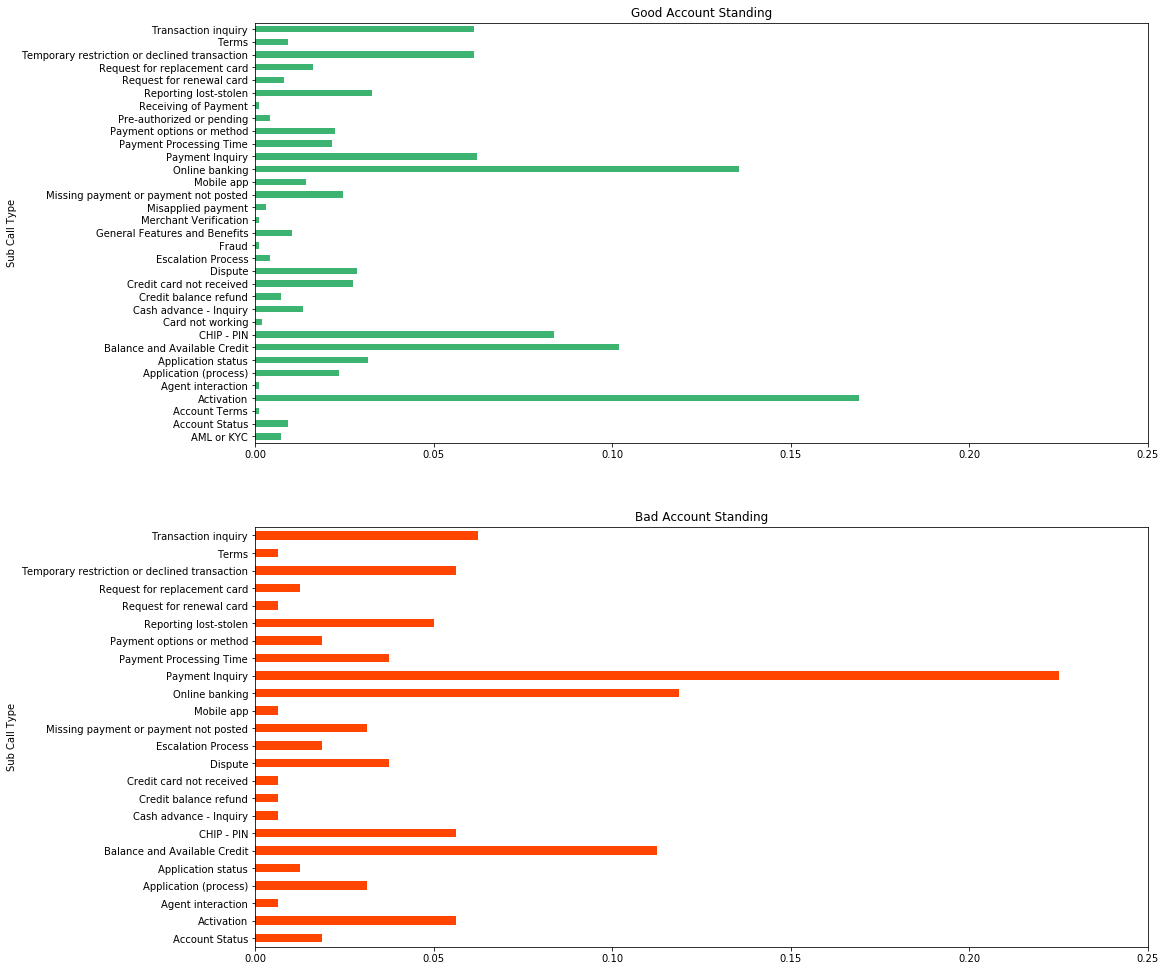

In [62]:
fig = plt.figure(figsize = (16, 17))


ax = fig.add_subplot(211)
(df_pos_accountstanding.groupby(["Sub Call Type"])["Call Type"].count() / df_pos_accountstanding.groupby(["Sub Call Type"])["Sub Call Type"].count().sum()).plot.barh(color = "mediumseagreen", ax = ax)
ax.set_xlim(0, 0.25)
ax.set_title("Good Account Standing")

ax2 = fig.add_subplot(212)
(df_neg_accountstanding.groupby(["Sub Call Type"])["Call Type"].count() / df_neg_accountstanding.groupby(["Sub Call Type"])["Sub Call Type"].count().sum()).plot.barh(color = "orangered", ax = ax2)
ax2.set_xlim(0, 0.25)
ax2.set_title("Bad Account Standing");

## Modeling

In [63]:
enrolled_onlinebank = processed_data.drop(columns = ["Enrolled in Paperless Statements",
                                                     "Enrolled in Paperless Documents"])
enrolled_statements = processed_data.drop(columns = ["Enrolled in Online Banking",
                                                     "Enrolled in Paperless Documents"])
enrolled_documents = processed_data.drop(columns = ["Enrolled in Online Banking",
                                                     "Enrolled in Paperless Statements"])

### Target: Online Banking
- 1 = Subscribed
- 0 = Not subscribed

In [64]:
y = enrolled_onlinebank["Enrolled in Online Banking"]
X = enrolled_onlinebank.drop(columns = "Enrolled in Online Banking")

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

#### Logistic Regression

In [66]:
logres = LogisticRegression()
scaler = StandardScaler()

pipe_logres = Pipeline(
                           [
                            ("scaler", scaler),
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", logres)
                            
                           ]
                    )

grid_logres_param = [
                    {
                        "selector__percentile": [10, 30, 50, 80, 100],
                        "clf__C": [0.001, 0.005, 0.01, 0.05, ]
                    }
                  ]

grid_logres = GridSearchCV(
                            estimator = pipe_logres, 
                            param_grid = grid_logres_param, 
                            cv = 5,
                            scoring = "roc_auc"
                           )


grid_logres = grid_logres.fit(X, y)
print("Best Estimator: " + str(grid_logres.best_estimator_))
print("Best Score: " + str(grid_logres.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score: 0.6222403237438621


In [67]:
logres = grid_logres.best_estimator_
logres.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [68]:
displaycoef(X.columns, logres[2].coef_[0], display_graph = False)

,Features,Coefficient
7,Call Type_Service Experience,-0.042523
1,Call Type_Account Information,-0.039101
23,Sub Call Type_Fraud,-0.029160
6,Call Type_Payment,-0.028710
0,Current Account Standing,-0.027490
5,Call Type_Customer Transaction,-0.027490
21,Sub Call Type_Dispute,-0.027355
361,accurate balanec,-0.023935
439,add wasn,-0.023042
242,account formally,-0.022667


In [69]:
print(classification_report(y_test, logres.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.60      0.58       112
           1       0.65      0.62      0.63       134

    accuracy                           0.61       246
   macro avg       0.61      0.61      0.61       246
weighted avg       0.61      0.61      0.61       246



#### Decision Tree

In [70]:
tree = DecisionTreeClassifier()

pipe_tree = Pipeline(
                           [
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", tree)
                           ]
                    )

pipe_tree_param = [
                    {
                        "selector__percentile": [10, 30, 50, 80, 100],
                        "clf__max_depth": [5, 8, 10, 15, 20],
                        "clf__min_samples_split": [30, 50, 100, 200, 500, 1000]
                    }
                  ]

grid_tree = GridSearchCV(
                            estimator = pipe_tree, 
                            param_grid = pipe_tree_param, 
                            cv = 5,
                            scoring = "f1"
                           )


grid_tree = grid_tree.fit(X, y)
print("Best Estimator: " + str(grid_tree.best_estimator_))
print("Best Score: " + str(grid_tree.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=5, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=200,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)
Best Score: 0.7176244160493119


In [71]:
tree = grid_tree.best_estimator_
tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=5, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=200,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [72]:
displaycoef(X.columns, tree[1].feature_importances_, display_graph = False)

,Features,Coefficient
397,activate try,0.000000
525,advise available,0.000000
526,advise baack,0.000000
527,advise bus,0.000000
528,advise business,0.000000
529,advise callback,0.000000
530,advise card,0.000000
531,advise change,0.000000
532,advise charge,0.000000
533,advise check,0.000000


In [73]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.45      0.55       112
           1       0.65      0.85      0.74       134

    accuracy                           0.67       246
   macro avg       0.68      0.65      0.64       246
weighted avg       0.68      0.67      0.65       246



### Target: Paperless Statements
- 1 = Subscribed
- 0 = Not subscribed

In [74]:
y = enrolled_statements["Enrolled in Paperless Statements"]
X = enrolled_statements.drop(columns = "Enrolled in Paperless Statements")

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

#### Logistic Regression

In [76]:
logres = LogisticRegression(class_weight = "balanced")
scaler = StandardScaler()

pipe_logres = Pipeline(
                           [
                            ("scaler", scaler),
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", logres)
                            
                           ]
                    )

grid_logres_param = [
                    {
                        "selector__percentile": [10, 30, 50, 80, 100],
                        "clf__C": [0.001, 0.005, 0.01, 0.05]
                    }
                  ]

grid_logres = GridSearchCV(
                            estimator = pipe_logres, 
                            param_grid = grid_logres_param, 
                            cv = 5,
                            scoring = "roc_auc"
                           )


grid_logres = grid_logres.fit(X, y)
print("Best Estimator: " + str(grid_logres.best_estimator_))
print("Best Score: " + str(grid_logres.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=50,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score: 0.5821217608965193


In [77]:
logres = grid_logres.best_estimator_
logres.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=50,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [78]:
displaycoef(X.columns, logres[2].coef_[0], display_graph = False)

,Features,Coefficient
1,Call Type_Account Information,-0.164120
9,Sub Call Type_Account Terms,-0.145981
1410,call activate,-0.143739
26,Sub Call Type_Misapplied Payment,-0.117401
3056,dispute previously,-0.112178
25,Sub Call Type_Merchant Verification,-0.110102
3049,dispute agent,-0.104395
31,Sub Call Type_Payment Options Or Method,-0.099791
32,Sub Call Type_Payment Processing Time,-0.097811
0,Current Account Standing,-0.096355


In [79]:
print(classification_report(y_test, logres.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       155
           1       0.43      0.26      0.33        91

    accuracy                           0.60       246
   macro avg       0.54      0.53      0.52       246
weighted avg       0.57      0.60      0.57       246



#### Decision Tree

In [80]:
tree = DecisionTreeClassifier(class_weight = "balanced")

pipe_tree = Pipeline(
                           [
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", tree)
                           ]
                    )

pipe_tree_param = [
                    {
                        "selector__percentile": [10, 30, 50, 80, 100],
                        "clf__max_depth": [5, 8, 10, 15, 20],
                        "clf__min_samples_split": [30, 50, 100, 200, 500, 1000]
                    }
                  ]

grid_tree = GridSearchCV(
                            estimator = pipe_tree, 
                            param_grid = pipe_tree_param, 
                            cv = 5,
                            scoring = "f1"
                           )


grid_tree = grid_tree.fit(X, y)
print("Best Estimator: " + str(grid_tree.best_estimator_))
print("Best Score: " + str(grid_tree.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=100,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=200,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)
Best Score: 0.5383241251226397


In [81]:
tree = grid_tree.best_estimator_
tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=100,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=200,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [82]:
displaycoef(X.columns, tree[1].feature_importances_, display_graph = False)

,Features,Coefficient
0,Current Account Standing,0.000000
5316,owe recently,0.000000
5315,owe provide,0.000000
5314,owe payment,0.000000
5313,owe minimujm,0.000000
5312,owe end,0.000000
5311,owe customer,0.000000
5310,owe check,0.000000
5309,owe brand,0.000000
5308,owe balance,0.000000


In [83]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       155
           1       0.42      0.41      0.41        91

    accuracy                           0.57       246
   macro avg       0.54      0.54      0.54       246
weighted avg       0.57      0.57      0.57       246



### Target: Paperless Documents
- 1 = Subscribed
- 0 = Not subscribed

In [84]:
y = enrolled_documents["Enrolled in Paperless Documents"]
X = enrolled_documents.drop(columns = "Enrolled in Paperless Documents")

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

#### Logistic Regression

In [86]:
logres = LogisticRegression(class_weight = "balanced")
scaler = StandardScaler()

pipe_logres = Pipeline(
                           [
                            ("scaler", scaler),
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", logres)
                           ]
                    )

grid_logres_param = [
                    {
                        "selector__percentile": [10, 30, 50, 80, 100],
                        "clf__C": [0.001, 0.005, 0.01, 0.05, ]
                    }
                  ]

grid_logres = GridSearchCV(
                            estimator = pipe_logres, 
                            param_grid = grid_logres_param, 
                            cv = 5,
                            scoring = "roc_auc"
                           )


grid_logres = grid_logres.fit(X, y)
print("Best Estimator: " + str(grid_logres.best_estimator_))
print("Best Score: " + str(grid_logres.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=50,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score: 0.5939274191532403


In [87]:
logres = grid_logres.best_estimator_
logres.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=50,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [88]:
displaycoef(X.columns, logres[2].coef_[0], display_graph = False)

,Features,Coefficient
2621,customer query,-0.115700
2891,decline tap,-0.109397
3849,inform fact,-0.105747
2,Call Type_Card Activation,-0.105594
3012,directly ask,-0.105369
316,account provide,-0.103941
1422,call card,-0.095140
1,Call Type_Account Information,-0.091137
6,Call Type_Payment,-0.091137
24,Sub Call Type_General Features And Benefits,-0.085718


In [89]:
print(classification_report(y_test, logres.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       160
           1       0.45      0.31      0.37        86

    accuracy                           0.63       246
   macro avg       0.57      0.55      0.55       246
weighted avg       0.60      0.63      0.61       246



#### Decision Tree

In [90]:
tree = DecisionTreeClassifier(class_weight = "balanced")

pipe_tree = Pipeline(
                           [
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", tree)
                           ]
                    )

pipe_tree_param = [
                    {
                        "selector__percentile": [5, 10, 30, 50, 80, 100],
                        "clf__max_depth": [5, 8, 10, 15, 20, 25, 30],
                        "clf__min_samples_split": [30, 50, 100, 200, 500, 1000]
                    }
                  ]

grid_tree = GridSearchCV(
                            estimator = pipe_tree, 
                            param_grid = pipe_tree_param, 
                            cv = 5,
                            scoring = "f1"
                           )


grid_tree = grid_tree.fit(X, y)
print("Best Estimator: " + str(grid_tree.best_estimator_))
print("Best Score: " + str(grid_tree.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=100,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=100,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)
Best Score: 0.5611745880772013


In [91]:
tree = grid_tree.best_estimator_
tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=100,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=100,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [92]:
displaycoef(X.columns, tree[1].feature_importances_, display_graph = False)

,Features,Coefficient
0,Current Account Standing,0.000000
5316,owe recently,0.000000
5315,owe provide,0.000000
5314,owe payment,0.000000
5313,owe minimujm,0.000000
5312,owe end,0.000000
5311,owe customer,0.000000
5310,owe check,0.000000
5309,owe brand,0.000000
5308,owe balance,0.000000


In [93]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.36      0.49       160
           1       0.41      0.84      0.55        86

    accuracy                           0.52       246
   macro avg       0.61      0.60      0.52       246
weighted avg       0.67      0.52      0.51       246



### Current Account Standing
- 1 = Good
- 0 = Bad

In [94]:
y = processed_data["Current Account Standing"]
X = processed_data.drop(columns = "Current Account Standing")

In [95]:
y = y.replace({0 : 1,
               1 : 0
              })

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

#### Logistic Regression

In [97]:
logres = LogisticRegression(class_weight = "balanced")
scaler = StandardScaler()

pipe_logres = Pipeline(
                           [
                            ("scaler", scaler),
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", logres)
                           ]
                    )

grid_logres_param = [
                    {
                        "selector__percentile": [10, 30, 50, 80, 100],
                        "clf__C": [0.001, 0.005, 0.01, 0.05, ]
                    }
                  ]

grid_logres = GridSearchCV(
                            estimator = pipe_logres, 
                            param_grid = grid_logres_param, 
                            cv = 5,
                            scoring = "roc_auc"
                           )


grid_logres = grid_logres.fit(X, y)
print("Best Estimator: " + str(grid_logres.best_estimator_))
print("Best Score: " + str(grid_logres.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score: 0.6537369498094425


In [98]:
logres = grid_logres.best_estimator_
logres.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [99]:
displaycoef(X.columns, logres[2].coef_[0], display_graph = False)

,Features,Coefficient
712,agree cusotmer,-0.048568
590,advise unable,-0.031928
751,alsoa dvised,-0.026201
251,account hang,-0.021220
468,address current,-0.014839
695,agent wasn,-0.014265
721,ahead use,-0.013876
605,agent affirm,-0.013013
593,advise wil,-0.007749
753,amazon approve,-0.001942


In [100]:
print(classification_report(y_test, logres.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       212
           1       0.16      0.09      0.11        34

    accuracy                           0.81       246
   macro avg       0.51      0.51      0.50       246
weighted avg       0.77      0.81      0.79       246



#### Decision Tree

In [101]:
tree = DecisionTreeClassifier(class_weight = "balanced")

pipe_tree = Pipeline(
                           [
                            ("selector", SelectPercentile(f_classif)),
                            ("clf", tree)
                           ]
                    )

pipe_tree_param = [
                    {
                        "selector__percentile": [5, 10, 30, 50, 80, 100],
                        "clf__max_depth": [5, 8, 10, 15, 20, 25, 30],
                        "clf__min_samples_split": [30, 50, 100, 200, 500, 1000]
                    }
                  ]

grid_tree = GridSearchCV(
                            estimator = pipe_tree, 
                            param_grid = pipe_tree_param, 
                            cv = 5,
                            scoring = "f1"
                           )


grid_tree = grid_tree.fit(X, y)
print("Best Estimator: " + str(grid_tree.best_estimator_))
print("Best Score: " + str(grid_tree.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=50,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)
Best Score: 0.28718343952055664


In [102]:
tree = grid_tree.best_estimator_
tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('selector',
                 SelectPercentile(percentile=10,
                                  score_func=<function f_classif at 0x000000000B30D400>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=50,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [103]:
displaycoef(X.columns, tree[1].feature_importances_, display_graph = False)

,Features,Coefficient
0,Enrolled in Online Banking,0.000000
523,advise advise,0.000000
524,advise agent,0.000000
525,advise application,0.000000
526,advise approve,0.000000
527,advise available,0.000000
528,advise baack,0.000000
529,advise bus,0.000000
530,advise business,0.000000
531,advise callback,0.000000


In [104]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       212
           1       0.21      0.21      0.21        34

    accuracy                           0.78       246
   macro avg       0.54      0.54      0.54       246
weighted avg       0.78      0.78      0.78       246

